In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
from scipy import stats
from scipy import special


In [35]:
def chiSquaredTest(data, modelfit, params, plot=False, verbose=True):
    
    normdata = np.sum(data)*modelfit/np.sum(modelfit)
    
    chiresults = stats.chisquare(data, normdata)
    df = data.size-len(params)
    print(chiresults)
    print('Chi squared per degrees freedom: ', chiresults.statistic/df)
    if plot:
        try:
            chibins = np.arange(0,int(chiresults.statistic*2),0.1)
        except:
            chibins = np.arange(0,100,0.1)
            
        fig, axs = plt.subplots(1,2)
        axs[0].title.set_text('Chi2 test')
        axs[0].set_ylabel('probability')
        axs[0].set_xlabel('Chi2 statistic')

        axs[0].plot(chibins, stats.chi2.pdf(chibins, df=len(data)-1))
        axs[0].vlines(chiresults.statistic,0,0.05, 'r')
        axs[0].text(chiresults.statistic,0.05, 'p-value: {}'.format(np.round(chiresults.pvalue,2)))
        axs[1].scatter(data,  modelfit, c='k')
        maxval = np.max(data)
        if any(maxval < modelfit):
            maxval = np.max(modelfit)
        axs[1].set_xlim(0,maxval)
        axs[1].set_ylim(0,maxval)
        axs[1].plot([0, maxval],[0, maxval], linestyle=':', color='k')
        axs[0].title.set_text('Chi2 test')
        axs[1].set_ylabel('fit values')
        axs[1].set_xlabel('actual values')
        plt.tight_layout()
        plt.show()
    return chiresults

Power_divergenceResult(statistic=158.010989010989, pvalue=6.1736003249757916e-24)
Chi squared per degrees freedom:  8.316367842683631
height : 4.55


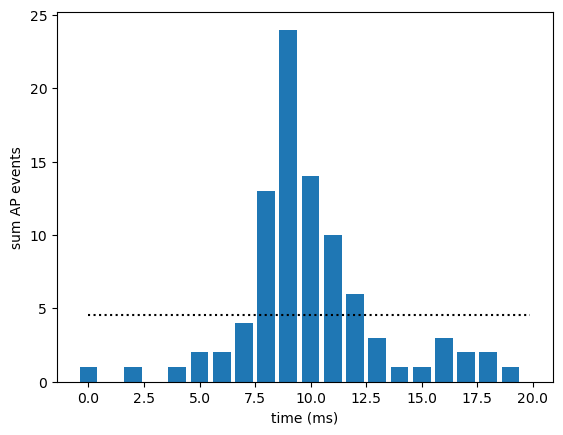

In [38]:
class fit_uniform():
    def __init__(self, data, X, init_params=None, verbose=False, plot=False):
        '''
        fit uniform distribution of binned data
        '''
        self.data = data
        self.X = X
        self.init_params = init_params
        self.verbose=verbose
        self.plot=plot

        if self.init_params == None:
            self.init_params =  self.uniform_params(self.data, self.X)

        error_function = lambda p: np.ravel(uniform(*p, self.X) - self.data)
        self.params, self.success = optimize.leastsq(error_function, self.init_params)
        self.chiresults = chiSquaredTest(self.data, self.uniform(*self.params, bins), self.params, plot=False)
        
    def uniform(self, height, X):
        return height*np.ones_like(X)

    def uniform_params(self, data, X):
        height = np.mean(data)
        return height
    
    def predict(self, x_new):
        return uniform(*self.params, x_new)
    
data = np.array([1,0,1,0,1,2,2,4,13,24,14,10,6,3,1,1,3,2,2,1])
bins = np.arange(0,data.shape[0],1)
interp = np.arange(0,data.shape[0],.1)

#data
model = fit_uniform(data, bins)

#print the fit parameters
param_labels = ['height']
for i, label in enumerate(param_labels):
    print(label, ':', np.round(model.params[i], 4))

#graph the data
plt.bar(bins, data)
plt.xlabel('time (ms)')
plt.ylabel('sum AP events')

plt.plot(interp, model.predict(interp), linestyle=':', c='black')
plt.show()



## Gaussian distribution

Power_divergenceResult(statistic=12.074500300222534, pvalue=0.8824162213750708)
Chi squared per degrees freedom:  0.7546562687639083
height : 19.8937
mean : 9.2047
std : 1.7302
base : 1.4996


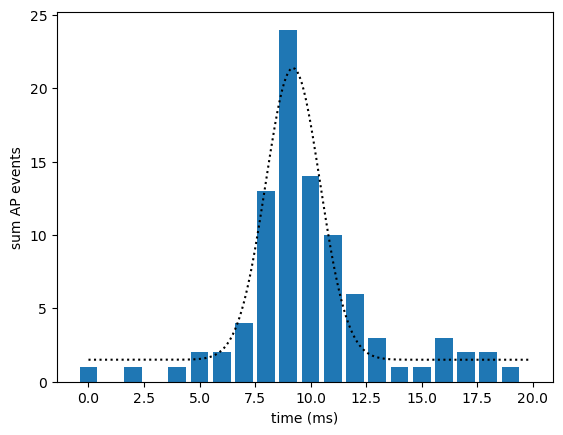

In [76]:
class fit_gaussian1D():
    def __init__(self, data, X=None, init_params=None, verbose=True, plot=False):
        '''
        fit 1D normal distribution with a uniform background of binned data
        '''
        self.data = data
        self.X = X
        self.init_params = init_params
        self.verbose=verbose
        self.plot=plot
        
        if self.X == None:
            self.X = np.indices(self.data.shape)
        if self.init_params == None:
            self.init_params = self.gaussian_moments()

        error_function = lambda p: np.ravel(self.gaussian(p, self.X) - data)
        self.params, self.success = optimize.leastsq(error_function, self.init_params)
        self.chiresults = chiSquaredTest(self.data, self.gaussian(self.params, bins), self.params, verbose=self.verbose, plot=self.plot)
        
    def gaussian_moments(self):
        '''
        Returns (height, x, y, width_x, width_y)
        the gaussian parameters of a 1D distribution
        '''
        base = np.mean(self.data[:5])
        datam = self.data
        datam[datam<0]=0
        total = datam.sum()
        xmean = (self.X*datam).sum()/total
        xsd = np.sqrt(np.abs(np.sum((self.X-xmean)**2*data)/np.sum(data)))
        height = datam.max()
        
        return [height, xmean, xsd, base]

    # Gaussian with uniform background
    def gaussian(self, params, X):
        height, xmean, xsd, base = params
        fxn = lambda x: height*np.exp(-(((xmean-x)/xsd)**2))+base
        return fxn(X)

    def predict(self, x):
        return self.gaussian(self.params, x)
            
data = np.array([1,0,1,0,1,2,2,4,13,24,14,10,6,3,1,1,3,2,2,1])

bins = np.arange(0,data.shape[0],1)
interp = np.arange(0,data.shape[0],.1)

#data
model = fit_gaussian1D(data)

#print the fit parameters
param_labels = ['height', 'mean', 'std', 'base']
for i, label in enumerate(param_labels):
    print(label, ':', np.round(model.params[i], 4))

#graph the data
plt.bar(bins, data)
plt.xlabel('time (ms)')
plt.ylabel('sum AP events')

plt.plot(interp, model.predict(interp), linestyle=':', c='black')
plt.show()


## von Mises 

Power_divergenceResult(statistic=13.215808057603997, pvalue=0.6569179189239476)
Chi squared per degrees freedom:  0.9439862898288569
height : 19.8937
mean : 9.2047
std : 1.7302


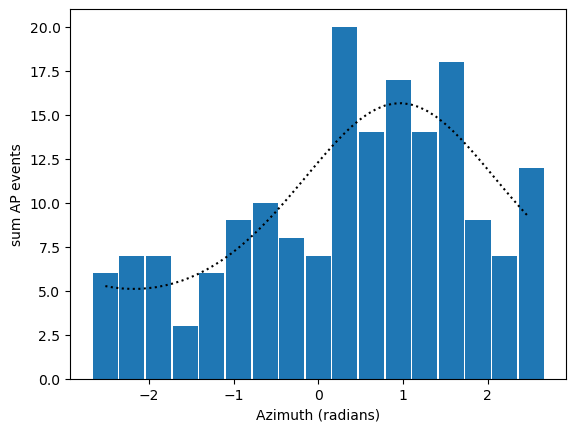

In [94]:
class fit_vonMises():
    def __init__(self, data, X=None, init_params=None, verbose=True, plot=False):
        '''
        fit vonMises distribution of binned data
        '''
        self.data = data
        self.X = X
        self.init_params = init_params
        self.verbose=verbose
        self.plot=plot
        
        if hasattr(X, "__len__"):
            self.X = X
        elif self.X == None:
            self.X = np.indices(self.data.shape)
            
        if self.init_params == None:
            self.init_params = self.vonmisesmoments(self.data, self.X)
        
        error_function = lambda p: np.ravel(self.vonMises(p, X) - data)
        self.params, success = optimize.leastsq(error_function, self.init_params)
        self.chiresults = chiSquaredTest(self.data, self.vonMises(self.params, self.X), self.params, plot=False)
        
    def vonMises(self, params, X):
        '''
        x in radians
        '''
        height, xmean, conc = params
        fxn = lambda x: height*np.exp(conc*np.cos(x-xmean))/(2*np.pi*special.jv(0, conc))
        return fxn(X)

    def vonmisesmoments(sefl, data, X):
        '''
        X in radians
        Returns (height, xmean, conc)
        the vonMises parameters of a 1D distribution
        '''

        datam = data
        datam[datam<0]=0
        total = datam.sum()

        xmean = (X*datam).sum()/total
        conc = np.sqrt(np.abs(np.sum((X-xmean)**2*data)/np.sum(data)))
        height = datam.max()

        return [height, xmean, conc]
    
    def predict(self, x_new):
        return self.vonMises(self.params, x_new)
    
data = np.array([ 6.,  7.,  7.,  3.,  6.,  9., 10.,  8.,  7., 20., 14., 17., 14., 18.,  9.,  7., 12.])
azim = np.array([-144, -126, -108, -90, -72, -54, -36, -18, 0, 18, 36, 54, 72, 90, 108, 126, 144])
azimrad = azim * (np.pi/180)
interp = np.arange(azimrad[0],azimrad[-1],.1)

#data
model = fit_vonMises(data, azimrad)

#print the fit parameters
param_labels = ['height', 'mean', 'std']
for i, label in enumerate(param_labels):
    print(label, ':', np.round(p[i], 4))

#graph the data
plt.bar(azimrad, data, width=(np.abs(np.min(azimrad))+np.abs(np.max(azimrad)))/len(data))
plt.xlabel('Azimuth (radians)')
plt.ylabel('sum AP events')
plt.plot(interp, model.predict(interp), linestyle=':', c='black')
plt.show()

## Kent distribution

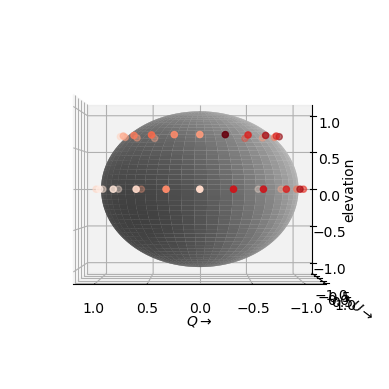

Iterating through 50 different parameter start points
	Working on 0 of 50 iterations
		 Singular matrix
		 Singular matrix
		 Singular matrix
		 Singular matrix
		 Singular matrix
		 Singular matrix
		 Singular matrix
		 Singular matrix
		 Singular matrix
		 Singular matrix
	Working on 10 of 50 iterations
		 Singular matrix
		 Singular matrix
		 Singular matrix
		 Singular matrix
		 Singular matrix
		 Singular matrix
		 Singular matrix
		 Singular matrix
		 Singular matrix
		 Singular matrix
	Working on 20 of 50 iterations
		 Singular matrix
		 Singular matrix
		 Singular matrix
		 Singular matrix
		 Singular matrix
		 Singular matrix
		 Singular matrix
		 Singular matrix
		 Singular matrix
		 Singular matrix
	Working on 30 of 50 iterations
		 Singular matrix
		 Singular matrix
		 Singular matrix
		 Singular matrix
		 Singular matrix
		 Singular matrix
		 Singular matrix
		 Singular matrix
		 Singular matrix
		 Singular matrix
	Working on 40 of 50 iterations
		 Singular matrix
		 Singu

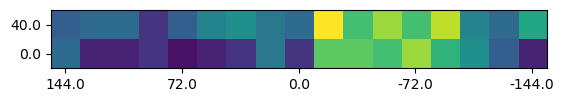

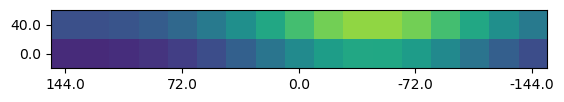

In [134]:
from collections import namedtuple


class kent_fit():
    def __init__(self, data, xyz, datashape, n_iter=50, init_params=None, verbose=True, plot=False):
        '''
        fit kent distribution of averaged data
        '''
        
        self.data = data
        self.xyz = xyz
        self.datashape = datashape
        self.verbose = verbose
        self.plot = plot
        self.param_labels =['kappa', 'beta', 'theta', 'phi', 'alpha', 'height']
        self.limits = ((0  , -0.5, -np.pi/4, -np.pi, -2*np.pi, 0),
                      (100,  0.5,  3*np.pi/2,  np.pi,  2*np.pi, 100))
        self.n_iter = n_iter
        
        
        iterations = namedtuple('iterations','init_params cov var residuals params success residual_sum')
        if self.verbose:
            print('Iterating through {} different parameter start points'.format(self.n_iter))
        for n in np.arange(n_iter):
            if (n % 10) == 0:
                print('\tWorking on {0} of {1} iterations'.format(n, self.n_iter))
            param = self.kentRandStart()
            error_function = lambda p: np.ravel(self.kent_dist_fit(p, xyz) - data)
            results = optimize.least_squares(error_function, param, bounds=self.limits)
            
            if n == 0:
                init_params = np.zeros((n_iter, len(self.param_labels)))*np.nan
                cov = np.zeros((n_iter, len(self.param_labels), len(self.param_labels)))*np.nan
                var = np.zeros((n_iter, len(self.param_labels)))*np.nan
                residuals = np.zeros((n_iter, self.xyz.shape[0]))*np.nan
                params = np.zeros((n_iter, len(self.param_labels)))*np.nan
                success = np.zeros((n_iter))*np.nan
                residual_sum = np.zeros((n_iter))*np.nan
            
            init_params[n] = np.squeeze(param)
            success[n] = results.success
            
            if success[n]:
                params[n] = results.x
                try:
                    jacobian = results.jac
                    cov[n] = np.linalg.inv(jacobian.T.dot(jacobian))
                    var[n] = np.sqrt(np.diagonal(cov))
                except Exception as e:
                    if self.verbose:
                        print('\t\t', e)
                residuals[n] = results.fun
                residual_sum[n] = np.sum(np.abs(residuals[n]))
        
        self.iterations = iterations(init_params, cov, var, residuals, params, success, residual_sum)
                        
        index = np.nanargmin(residual_sum)
        self.params = params[index]        
#         self.var = var[index]
        self.residuals = residuals[index]
        
        self.fitdist = self.kent_dist_fit(self.params, self.xyz).reshape(self.datashape)
        self.data = data.reshape(self.datashape)
        self.chiresults = chiSquaredTest(self.data.reshape(self.data.size), self.fitdist.reshape(self.fitdist.size), self.params)
                        
    def kent(self, xyz, height, beta, kappa, gamma1, gamma2, gamma3):
        # definition of the kent distribution
        kent_dist = height * np.exp(-kappa) * np.exp(kappa * np.dot(xyz, gamma1) + 
                beta * kappa * (np.dot(xyz, gamma2)**2 - np.dot(xyz, gamma3)**2))
        return np.squeeze(kent_dist)
    
    def rodrot(self, targetvector, rotationaxis, angle):
        # this function does rotation of a vector in 3d space accordingly to
        # Rodrigues rotation formula.

        r1 = targetvector*np.cos(angle)
        r2 = np.cross(rotationaxis, targetvector) * np.sin(angle)
        r3 = rotationaxis * (np.transpose(rotationaxis) * targetvector) * (1 - np.cos(angle))

        return np.squeeze(r1 + r2 + r3)
    
    def sph2cart(self, theta, phi):
        # this returns cartesian coord based on the spherical coordinates.
        # this assumes a unit circle
        return [np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]
    
    
    def sphericalUnit(self, theta, phi):
        # this function gives a unit vectors of spherical coordinates.
        # the notation is based on Arfken
        # theta is polar angle
        # phi is azimuthal angle.
        st = np.sin(theta);
        ct = np.cos(theta);
        sp = np.sin(phi);
        cp = np.cos(phi);
        unitvecs = np.array([[st * cp,  ct * cp, -sp],
                    [st * sp,  ct * sp,  cp],
                    [ct,      -st,      0]])
        
        return unitvecs
    
    def kent_dist_fit(self, params, xyz):
        kappa, beta, theta, phi, alpha, height = params
        alpha = 45

        theta_degree = 45 
        theta = theta_degree*np.pi/180

        phi_degree = 45
        phi = (90+phi_degree)*np.pi/180

        n_samples = xyz.shape[0]

        unitvecs = self.sphericalUnit(theta, phi)
        gamma1 = unitvecs[:, 0]

        gamma2 = self.rodrot(unitvecs[:, 1], unitvecs[:, 0], alpha)
        gamma3 = self.rodrot(unitvecs[:, 2], unitvecs[:, 0], alpha)

        gamma1 = np.transpose(gamma1[None,None,:], [1, 2, 0])
        gamma2 = np.transpose(gamma2[None,None,:], [1, 2, 0])
        gamma3 = np.transpose(gamma3[None,None,:], [1, 2, 0])

        return self.kent(xyz, height, beta, kappa, gamma1, gamma2, gamma3)

    def kentRandStart(self):
        kappa = np.random.uniform(low=0, high=100, size=1)
        beta = np.random.uniform(low=-0.5, high=0.5, size=1)
        theta = np.random.uniform(low=0, high=np.pi/2, size=1)
        phi =  np.random.uniform(low = -144 / 180 * np.pi, high = 144 / 180 * np.pi, size=1)
        alpha = np.random.uniform(low = -2*np.pi, high = 2*np.pi, size=1)
        height = np.random.uniform(low=0, high=100, size=1)

        return np.squeeze(np.array([kappa, beta, theta, phi, alpha, height]))
    
data = np.array([[ 7.,  2.,  2.,  3.,  1.,  2.,  3.,  8.,  3., 15., 15., 14., 17., 13., 10.,  6.,  2.],
                 [ 6.,  7.,  7.,  3.,  6.,  9., 10.,  8.,  7., 20., 14., 17., 14., 18.,  9.,  7., 12.]])


from mpl_toolkits.mplot3d import Axes3D

def grid3d(gridsize = 200):

    u = np.linspace(0, 2 * np.pi, gridsize)
    v = np.linspace(0, np.pi, gridsize)

    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
#     keys = list()
#     points = list()
#     for i in range(gridsize):
#         for j in range(gridsize):
#             points.append([x[i, j], y[i, j], z[i, j]])
#             keys.append((i, j))
#     points = np.array(points)

#     value_for_color = np.ones(gridsize)
#     colors = np.empty((gridsize, gridsize), dtype=tuple)
#     for i, j in keys:
#         colors[i, j] = (1.0, 1.0, 1.0, 1.0)
        
    return x, y, z#, points, colors

azim = -1*np.array([-144, -126, -108, -90, -72, -54, -36, -18, 0, 18, 36, 54, 72, 90, 108, 126, 144])
elev = 90-np.array([0,40])
azim = azim*np.pi/180
elev = elev*np.pi/180

def azimElevCoord(azim, elev, data):
    corz = np.cos(elev)
    xs = np.zeros([elev.shape[0]*azim.shape[0],4])
    n=0
    
    for k in np.arange(corz.shape[0]):
        corx = np.sin(elev[k])*np.sin(azim)
        cory = np.sin(elev[k])*np.cos(azim)
        for i in np.arange(corx.shape[0]):
            xs[n,0] = corx[i]
            xs[n,1] = cory[i]
            xs[n,2] = corz[k]
            xs[n,3] = data[k,i]
            n+=1
    return xs


x, y, z = grid3d(gridsize = 200)

xs = azimElevCoord(azim, elev, data)

f = plt.figure()

ax = f.add_subplot(111, projection='3d')
xx, yy, zz, colors = list(zip(*xs))  # plot only a portion of these values
ax.scatter(1.05 * np.array(xx), 1.05 *
           np.array(yy), 1.05 * np.array(zz), c=colors, cmap='Reds', vmin=0, vmax=20)
ax.plot_surface(x, y, z, rstride=4, cstride=4,
                color='lightgray',
#             facecolors=colors, 
            linewidth=0)
ax.set_xlabel(r"$Q\rightarrow$")
ax.set_ylabel(r"$U\rightarrow$")
ax.set_zlabel('elevation')
# ax.set_zlim(0,1)
ax.view_init(0,90)
# plt.savefig(savedir + 'binned_fr_data_sphere.svg', dpi=300)
plt.show()


interp = np.arange(azimrad[0],azimrad[-1],.1)

xyz = xs[:,:3]

#data
model = kent_fit(xs[:,3], xyz , datashape = data.shape)
for pa, param in enumerate(model.param_labels):
    print(param, model.params[pa])

maxval = np.max(data)
minval=0
plt.imshow(model.data, vmin=minval, vmax=maxval)
plt.xticks(np.arange(azim.shape[0])[::4], np.round(azim * 180/np.pi)[::4])
plt.yticks(np.arange(elev.shape[0]), np.round(90-elev * 180/np.pi))
plt.ylim(-0.5,1.5)
plt.show()

plt.imshow(model.fitdist, vmin=minval, vmax=maxval)
plt.xticks(np.arange(azim.shape[0])[::4], np.round(azim * 180/np.pi)[::4])
plt.yticks(np.arange(elev.shape[0]), np.round(90-elev * 180/np.pi))
plt.ylim(-0.5,1.5)
plt.show()


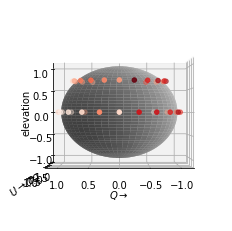

kappa 1.1120170066623463
beta -0.004916467869406517
theta 0.7334823001713396
phi -2.399319788369424
alpha -2.6116138544129415
height 17.086968613517215
base 0.24322056998001498


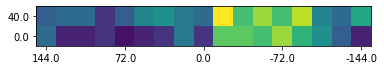

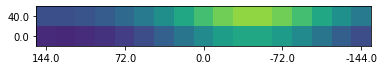

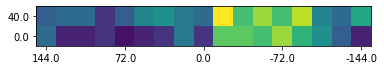

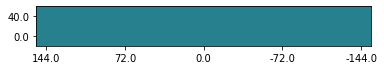

height : 8.7353
Power_divergenceResult(statistic=42.57823939295884, pvalue=0.12273803355612878)


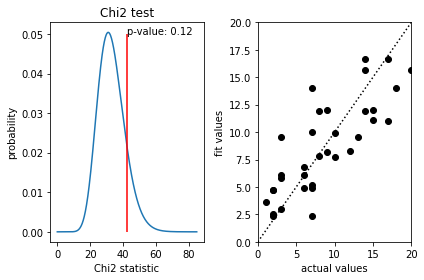

Power_divergenceResult(statistic=109.28282828282829, pvalue=4.233976941704028e-10)


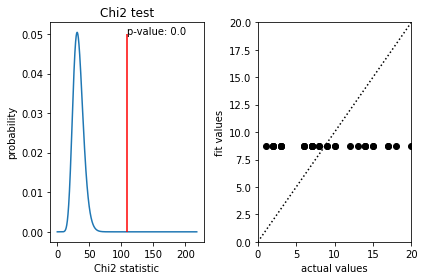

In [11]:
data = np.array([[ 7.,  2.,  2.,  3.,  1.,  2.,  3.,  8.,  3., 15., 15., 14., 17., 13., 10.,  6.,  2.],
                 [ 6.,  7.,  7.,  3.,  6.,  9., 10.,  8.,  7., 20., 14., 17., 14., 18.,  9.,  7., 12.]])


from mpl_toolkits.mplot3d import Axes3D

def grid3d(gridsize = 200):

    u = np.linspace(0, 2 * np.pi, gridsize)
    v = np.linspace(0, np.pi, gridsize)

    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
#     keys = list()
#     points = list()
#     for i in range(gridsize):
#         for j in range(gridsize):
#             points.append([x[i, j], y[i, j], z[i, j]])
#             keys.append((i, j))
#     points = np.array(points)

#     value_for_color = np.ones(gridsize)
#     colors = np.empty((gridsize, gridsize), dtype=tuple)
#     for i, j in keys:
#         colors[i, j] = (1.0, 1.0, 1.0, 1.0)
        
    return x, y, z#, points, colors

azim = -1*np.array([-144, -126, -108, -90, -72, -54, -36, -18, 0, 18, 36, 54, 72, 90, 108, 126, 144])
elev = 90-np.array([0,40])
azim = azim*np.pi/180
elev = elev*np.pi/180

def azimElevCoord(azim, elev, data):
    corz = np.cos(elev)
    xs = np.zeros([elev.shape[0]*azim.shape[0],4])
    n=0
    
    for k in np.arange(corz.shape[0]):
        corx = np.sin(elev[k])*np.sin(azim)
        cory = np.sin(elev[k])*np.cos(azim)
        for i in np.arange(corx.shape[0]):
            xs[n,0] = corx[i]
            xs[n,1] = cory[i]
            xs[n,2] = corz[k]
            xs[n,3] = data[k,i]
            n+=1
    return xs


x, y, z = grid3d(gridsize = 200)

xs = azimElevCoord(azim, elev, data)

f = plt.figure()

ax = f.add_subplot(111, projection='3d')
xx, yy, zz, colors = list(zip(*xs))  # plot only a portion of these values
ax.scatter(1.05 * np.array(xx), 1.05 *
           np.array(yy), 1.05 * np.array(zz), c=colors, cmap='Reds', vmin=0, vmax=20)
ax.plot_surface(x, y, z, rstride=4, cstride=4,
                color='lightgray',
#             facecolors=colors, 
            linewidth=0)
ax.set_xlabel(r"$Q\rightarrow$")
ax.set_ylabel(r"$U\rightarrow$")
ax.set_zlabel('elevation')
# ax.set_zlim(0,1)
ax.view_init(0,90)
# plt.savefig(savedir + 'binned_fr_data_sphere.svg', dpi=300)
plt.show()


interp = np.arange(azimrad[0],azimrad[-1],.1)

xyz = xs[:,:3]

#data
p = fitKent(data.reshape(data.size), xyz)
param_labels = ['kappa', 'beta', 'theta', 'phi', 'alpha', 'height', 'base']
for pa, param in enumerate(param_labels):
    print(param, p[pa])

#graph the data

fitdist = kentdist(*p, xyz).reshape(data.shape)

maxval = np.max(data)
minval=0
plt.imshow(data, vmin=minval, vmax=maxval)
plt.xticks(np.arange(azim.shape[0])[::4], np.round(azim * 180/np.pi)[::4])
plt.yticks(np.arange(elev.shape[0]), np.round(90-elev * 180/np.pi))
plt.ylim(-0.5,1.5)
plt.show()

plt.imshow(fitdist, vmin=minval, vmax=maxval)
plt.xticks(np.arange(azim.shape[0])[::4], np.round(azim * 180/np.pi)[::4])
plt.yticks(np.arange(elev.shape[0]), np.round(90-elev * 180/np.pi))
plt.ylim(-0.5,1.5)
plt.show()



#data
p = fitUniform(data.reshape(data.size), np.arange(data.size))
ufit = uniform(*p, np.arange(data.size))

plt.imshow(data, vmin=minval, vmax=maxval)
plt.xticks(np.arange(azim.shape[0])[::4], np.round(azim * 180/np.pi)[::4])
plt.yticks(np.arange(elev.shape[0]), np.round(90-elev * 180/np.pi))
plt.ylim(-0.5,1.5)
plt.show()

plt.imshow(ufit.reshape(data.shape), vmin=minval, vmax=maxval)
plt.xticks(np.arange(azim.shape[0])[::4], np.round(azim * 180/np.pi)[::4])
plt.yticks(np.arange(elev.shape[0]), np.round(90-elev * 180/np.pi))
plt.ylim(-0.5,1.5)
plt.show()

#print the fit parameters
param_labels = ['height']
for i, label in enumerate(param_labels):
    print(label, ':', np.round(p[i], 4))

kentres = chiSquaredTest(data.reshape(data.size), fitdist.reshape(fitdist.size))

unires = chiSquaredTest(data.reshape(data.size), ufit)
